# Case Study 1 - Climate Change Resilience

In [ ]:
%load_ext autoreload
%autoreload 2
import n_fct_t_rl_thm_ll as bond_create
import functions as fct
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import exposures_cc as ex_cc
import impact as cimp
import bound_prot_dam as bpd
import haz_int_grd as hig
import alt_pay_opt as apo
import simulate_bond as sb
import prem_ibrd as prib
import calc_premium as cp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
#choose country
country = 882

#number of simulated years
r = 10000

#define maximum and minimum return periods to be covered
lower_share = 0.05
upper_rp = 250

target_sharpe = 0.5
rf_rate = 0.0
 
#define global circulation models
cc_models = ["CMCC", "CNRM", "ECEARTH", "HADGEM"]

OUTPUR_DIR = Path("C:/Users/Kai/OneDrive - UT Cloud/Documents/Studium_ETH/Thesis/Data/cty_data")
STORM_DIR = Path("C:/Users/kaibe/Documents/ETH_Zurich/Thesis/Data/hazard/tc_tracks/storm_tc_tracks/climate_change")

Simulate bond using present climate condtions

In [ ]:

bond_metrics_dic = {}
bond_returns_dic = {}
premium_dic_dic = {}
nominal_dic = {}
pay_dam_df_dic = {}
es_metrics_dic = {}
int_grid_dic = {}
imp_per_event_flt_dic = {}
imp_admin_evt_flt_dic = {}
ann_losses_dic = {}

bond_metrics_dic['CRCL'], bond_returns_dic['CRCL'], premium_dic_dic['CRCL'], nominal_dic['CRCL'], pay_dam_df_dic['CRCL'], es_metrics_dic['CRCL'], int_grid_dic['CRCL'], imp_per_event_flt_dic['CRCL'], imp_admin_evt_flt_dic['CRCL'], ann_losses_dic['CRCL'], optimized_1, optimized_2 = bond_create.sng_cty_bond_test(country, grid_specs=[5,5], grid_size=1000, 
                                                                                                                                                                                                                                                                                                                  prot_rp=upper_rp, to_prot_share=lower_share,
                                                                                                                                                                                                                                                                                                                  output_dir=OUTPUR_DIR, ibrd_path=Path("C:/Users/Kai/OneDrive - UT Cloud/Documents/Studium_ETH/Thesis"))

Number of tracks in SP basin: 3002
The principal of the cat bond is: 316652842.906 [USD]
Principal as share of GDP: 0.364


Simulate bond for future climate condtions

In [ ]:

for cc_model in cc_models:

    exp, applicable_basin, grid_gdf, admin_gdf, storm_basin_sub, tc_storms = ex_cc.init_TC_exp(country=country, cc_model=cc_model, grid_specs=[5,5], buffer_grid_size=1, res_exp=30, 
                                                                                               file_path=OUTPUR_DIR, storm_path=STORM_DIR, load_fls=True, plot_exp=False, plot_centrs=False, 
                                                                                               plt_grd=False)
    #calculate impact and aggregate impact per grid
    imp, imp_per_event, imp_admin_evt = cimp.init_imp(exp, tc_storms, admin_gdf, plot_frequ=False) 
    imp_per_event_flt, imp_admin_evt_flt, imp_lower_rp = bpd.init_imp_flt(imp_per_event, imp_admin_evt, prot_share=lower_share, exposure=exp)
    #set up hazard intensity matrix per grid and event
    int_grid = hig.init_haz_int(grid_gdf, admin_gdf, tc_storms=tc_storms, stat=60, cc_model=cc_model)
    
    premium_dic = {'ibrd': 0, 'regression': 0, 'required': 0}
    
    nominal = nominal_dic['CRCL']
    
    #create data frame containing payment vs damage per event
    pay_dam_df = apo.alt_pay_vs_damage(imp_per_event_flt, optimized_1, optimized_2, int_grid, nominal, imp_admin_evt)
    #calculate expected loss and attachment probability
    exp_loss_ann, att_prob, ann_losses, es_metrics = sb.init_exp_loss_att_prob_simulation(pay_dam_df, nominal, print_prob=False)
    #calculate premiums using different approaches
    requ_prem = sb.init_prem_sharpe_ratio(ann_losses, rf_rate, target_sharpe)
    params_ibrd = prib.init_prem_ibrd(file_path=Path("C:/Users/Kai/OneDrive - UT Cloud/Documents/Studium_ETH/Thesis"), want_plot=False)
    a, k, b = params_ibrd
    ibrd_prem = prib.monoExp(exp_loss_ann*100, a, k, b) * exp_loss_ann
    premium_dic['regression'] = cp.calc_premium_regression(exp_loss_ann *100)/100
    premium_dic['required'] = requ_prem
    premium_dic['ibrd'] = ibrd_prem
    
    #simulate cat bond
    bond_metrics_list = []
    bond_returns_list = []
    #simulate cat bond
    for prem in premium_dic:
        bond_metrics, bond_returns = sb.init_bond_simulation(pay_dam_df, premium_dic[prem], rf_rate, nominal) 
        bond_metrics["Premium Name"] = prem
        bond_returns["Premium Name"] = prem
        bond_metrics_list.append(bond_metrics)
        bond_returns_list.append(bond_returns)
    bond_metrics = pd.concat(bond_metrics_list, ignore_index=True)
    bond_returns = pd.concat(bond_returns_list, ignore_index=True)
    premium_dic['exp_loss'] = exp_loss_ann
    premium_dic['att_prob'] = att_prob

    bond_metrics_dic[cc_model] = bond_metrics
    bond_returns_dic[cc_model] = bond_returns
    premium_dic_dic[cc_model] = premium_dic
    nominal_dic[cc_model] = nominal
    pay_dam_df_dic[cc_model] = pay_dam_df
    es_metrics_dic[cc_model] = es_metrics
    int_grid_dic[cc_model] = int_grid
    imp_per_event_flt_dic[cc_model] = imp_per_event_flt
    imp_admin_evt_flt_dic[cc_model] = imp_admin_evt_flt
    ann_losses_dic[cc_model] = ann_losses

Number of tracks in SP basin: 2708
Number of tracks in SP basin: 4133
Number of tracks in SP basin: 3188
Number of tracks in SP basin: 2718


Plot relevant metrics

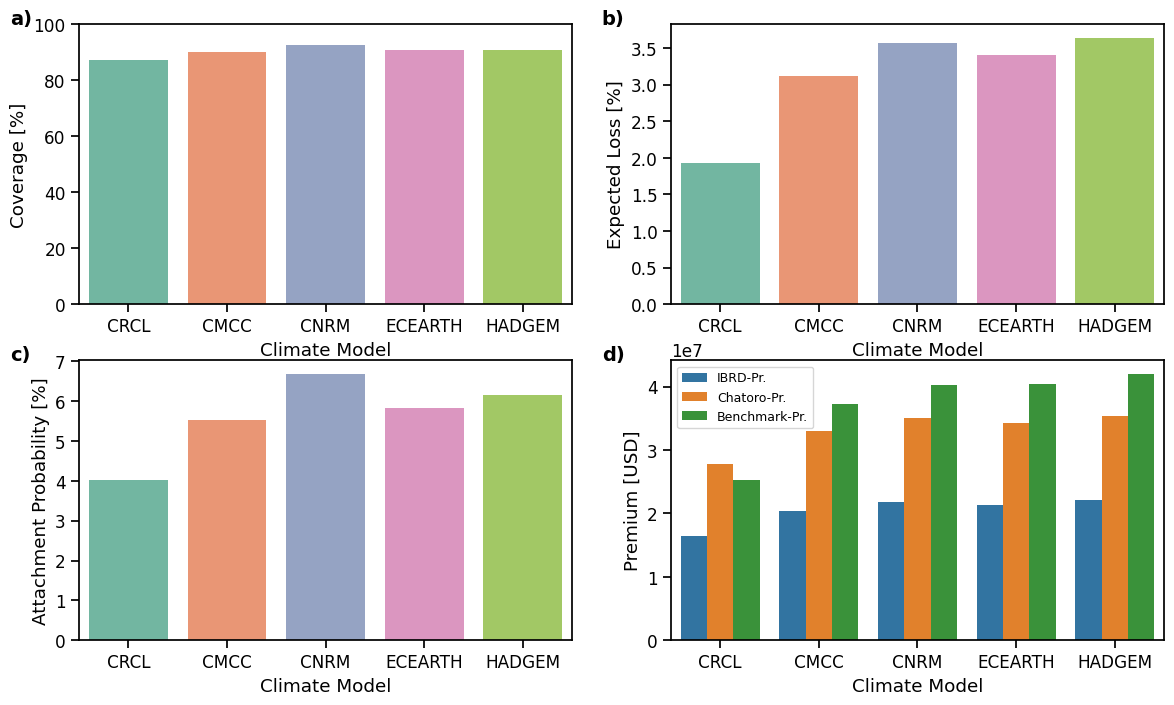

In [89]:
tc_sets = ["CRCL", "CMCC", "CNRM", "ECEARTH", "HADGEM"]
tc_sets_rep = [item for item in tc_sets for _ in range(3)]
cc_cond = ["Present Climate", "Climate Change", "Climate Change", "Climate Change", "Climate Change"]

cc_coverage = []
prem_data = []
cc_exp_loss = []
cc__att_prob = []
for i, mod in enumerate(tc_sets):
    cc_coverage.append(bond_metrics_dic[mod]['Coverage'][0])
    cc_exp_loss.append(premium_dic_dic[mod]['exp_loss'])
    cc__att_prob.append(premium_dic_dic[mod]['att_prob'])
    prem_data.append({"Climate Condition": cc_cond[i], "Premium Type": "ibrd", "Premium [USD]": premium_dic_dic[mod]['ibrd'] * nominal_dic[mod]})
    prem_data.append({"Climate Condition": cc_cond[i], "Premium Type": "regression", "Premium [USD]": premium_dic_dic[mod]['regression'] * nominal_dic[mod]})
    prem_data.append({"Climate Condition": cc_cond[i], "Premium Type": "required", "Premium [USD]": premium_dic_dic[mod]['required'] * nominal_dic[mod]})

cc_coverage = np.array(cc_coverage).flatten()
cc_exp_loss = np.array(cc_exp_loss).flatten()
cc__att_prob = np.array(cc__att_prob).flatten()
prem_data = pd.DataFrame(prem_data)
prem_data['Climate Model'] = tc_sets_rep
prem_data['Premium Type'] = prem_data['Premium Type'].replace({'ibrd': 'IBRD-Pr.', 'regression': 'Chatoro-Pr.', 'required': 'Benchmark-Pr.'})

df_coverage = {'Coverage [%]': cc_coverage*100, 'Climate Condition': cc_cond, 'Climate Model': tc_sets}
df_exp_loss = {'Expected Loss [%]': cc_exp_loss*100, 'Climate Condition': cc_cond, 'Climate Model': tc_sets}
df_att_prob = {'Attachment Probability [%]': cc__att_prob*100, 'Climate Condition': cc_cond, 'Climate Model': tc_sets}

sns.set_context("notebook", font_scale=1.1)
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
ax1, ax2, ax3, ax4 = axes.ravel() 
marker_types = ['o','s', '^']
#sns.set_context("notebook", font_scale=1)
palette = sns.color_palette("Set2", n_colors=len(df_coverage['Climate Model']))
sns.barplot(y='Coverage [%]', x='Climate Model', data=df_coverage, ax=ax1, hue='Climate Model', legend=False, palette=palette)
sns.barplot(y='Expected Loss [%]', x='Climate Model', data=df_exp_loss, ax=ax2, hue='Climate Model', legend=False, palette=palette)
sns.barplot(y='Attachment Probability [%]', x='Climate Model', data=df_att_prob, ax=ax3, hue='Climate Model', legend=False, palette=palette)

sns.barplot(y='Premium [USD]', x='Climate Model', data=prem_data, ax=ax4, hue='Premium Type')

panel_labels = ["a)", "b)", "c)", "d)"]
for i, ax in enumerate([ax1, ax2, ax3, ax4]):
    ax.annotate(panel_labels[i], 
                xy=(-0.14, 1),  # Position: top-left corner
                xycoords="axes fraction",  # Relative to axes
                fontsize=14, 
                fontweight="bold")

ax1.set_ylim(0,100)
ax4.legend(fontsize=9)
plt.show()

In [90]:
print('Coverage: ',df_coverage['Coverage [%]'])
print('Expected Loss: ',df_exp_loss['Expected Loss [%]'])
print('Attachment Probability: ',df_att_prob['Attachment Probability [%]'])

Coverage:  [87.17748611 89.95010269 92.57376572 90.72728879 90.87937773]
Expected Loss:  [1.93315251 3.11338935 3.57008456 3.40708345 3.64351207]
Attachment Probability:  [4.02787503 5.5316595  6.6920076  5.83508386 6.14851122]


Assess change in premiums per pricing appraoch

In [86]:
crcl_premiums = prem_data[prem_data['Climate Model'] == 'CRCL'][['Premium Type', 'Premium [USD]']]
crcl_premiums = crcl_premiums.rename(columns={'Premium [USD]': 'CRCL Premium'})

merged_data = prem_data[prem_data['Climate Model'] != 'CRCL'].merge(
    crcl_premiums,
    on='Premium Type',
    how='left'
)

merged_data['Percentage Change'] = (
    (merged_data['Premium [USD]'] - merged_data['CRCL Premium']) / merged_data['CRCL Premium'] * 100
)

result = merged_data.groupby('Premium Type')['Percentage Change'].agg(['min', 'max'])

print(result)

                     min        max
Premium Type                       
Benchmark-Pr.  47.592779  66.604641
Chatoro-Pr.    18.807543  27.255260
IBRD-Pr.       23.941323  34.033173


Generate tropical cyclone hazard dictionaries

In [87]:
import exposures_cc as ex_cc
import exposures_alt as exa
tc_storms_dic = {}
for mod in cc_models:    
    exp, applicable_basin, grid_gdf, admin_gdf, storm_basin_sub, tc_storms = ex_cc.init_TC_exp(country=country, cc_model=mod, grid_specs=[2,2], buffer_grid_size=105, buffer_distance_km=1, res_exp=30, min_pol_size=500, file_path=OUTPUR_DIR, storm_path=STORM_DIR, load_fls=True, plot_exp=False, plot_centrs=False, plt_grd=False)
    tc_storms_dic[mod] = tc_storms

exp, applicable_basins, grid_gdf, admin_gdf, storm_basin_sub, tc_storms = exa.init_TC_exp(country, grid_specs=[2,2], buffer_distance_km=105, res_exp=30, min_pol_size=500, buffer_grid_size=1, file_path=OUTPUR_DIR, load_fls=True, plot_exp=False, plot_centrs=False, plt_grd=False)
tc_storms_dic['CRCL'] = tc_storms

Number of tracks in SP basin: 2708
Number of tracks in SP basin: 4133
Number of tracks in SP basin: 3188
Number of tracks in SP basin: 2718
Number of tracks in SP basin: 3002


Create histograms according to categories

<Axes: xlabel='Tropical Cyclone Category', ylabel='Share per Category (%)'>

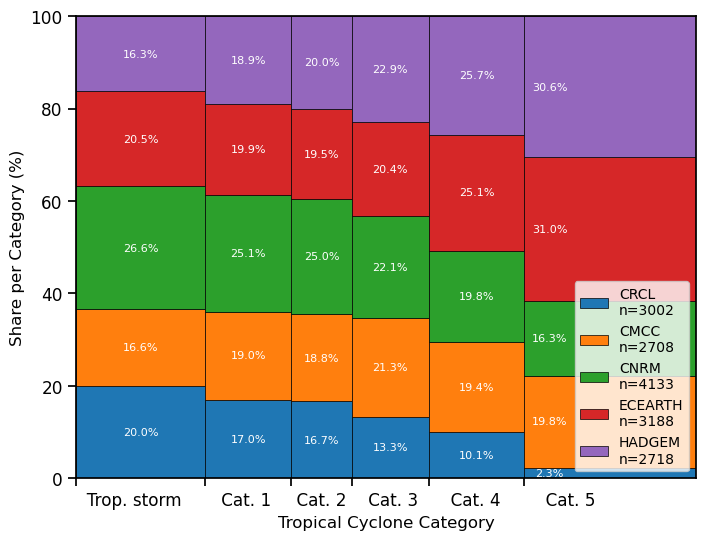

In [88]:
categories_plot = np.array([18, 33, 43, 50, 59, 70, 120]) #TC
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
fct.plot_TC_hist_cc(tc_storms_dic, categories_plot, ax)